# ALeRCE classes

https://github.com/ZwickyTransientFacility/ztf-avro-alert

1. **AGN:** Active Galactic Nuclei
1. **Blazar:** Blazar
1. **CV/Nova:** Cataclysmic Variable Star/Nova
1. **Ceph:** Cepheid Variable Star
1. **DSCT:** Delta Scuti Star
1. **EA:** Eclipsing Algol
1. **EB/EW:** Eclipsing Binaries/Eclipsing W Ursa Majoris
1. **LPV:** Long Period Variable
1. **Periodic-Other:** Periodic-Other
1. **QSO:** Quasi-Stellar Object
1. **RRL:** RRLyrae Variable Star
1. **RSCVn:** RS Canum Venaticorum
1. **SLSN:** Super Luminous Supernova
1. **SNII:** Supernova II
1. **SNIIb:** Supernova IIb
1. **SNIIn:** Supernova IIn
1. **SNIa:** Supernova Ia
1. **SNIbc:** Supernova Ibc
1. **TDE:** Tidal disruption event (to remove)
1. **YSO:** Young Stellar Object
1. **ZZ:** ZZ Ceti Stars (to remove)

In [1]:
import sys
sys.path.append('../../../')
sys.path.append('../../../../flaming-choripan')

In [11]:
%load_ext autoreload
%autoreload 2
from lchandler.survey_export.alerce_utils import process_df_labels, process_df_detections
import numpy as np
import pandas as pd

load_rootdir = '/home/opimentel/tesis/surveys_data'
survey_name = 'alerceZTFv7.1'
uses_corr = False # False only with SNes
df_index_names = {
    'oid':'oid', # object id
    'oid_det':'objectId', # object id
    'label':'classALeRCE', # object class name
    'ra':'ra',
    'dec':'dec',
    'band':'fid', # band
    'obs_day':'mjd', # days
    'obs':'magpsf_corr' if uses_corr else 'magpsf', # observations
    'obs_error':'sigmapsf_corr' if uses_corr else 'sigmapsf', # observation errors
}
detections_cols = ['objectId', 'fid', 'mjd', df_index_names['obs'], df_index_names['obs_error']]

### load files and processing
detections_df = pd.read_parquet(f'{load_rootdir}/{survey_name}/detections_with_xmatch')
detections_df, det_objs = process_df_detections(detections_df, df_index_names['oid_det'], df_index_names['oid'], detections_cols, uses_corr=uses_corr)
print(f'detections_df - columns: {list(detections_df.columns)} - id: {detections_df.index.name}')

labels_df = pd.read_csv(f'{load_rootdir}/{survey_name}/dfcrossmatches_prioritized_v7.0.1.csv')
labels_df,_ = process_df_labels(labels_df, df_index_names['oid'], det_objs)
print(f'labels - columns: {list(labels_df.columns)} - id: {labels_df.index.name}')

### print info
classes = set(labels_df[df_index_names['label']].values)
print('classes:', classes)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
detections_df - columns: ['fid', 'mjd', 'magpsf', 'sigmapsf'] - id: oid
labels - columns: ['classALeRCE', 'ra', 'dec', 'period', 'source', 'id_source', 'class_source', 'separation_arcsec'] - id: oid
classes: {'NLQSO', 'QSO', 'LPV', 'SNIa', 'AGN', 'Blazar', 'NLAGN', 'SNII', 'ZZ', 'SNIIn', 'EA', 'RRL', 'Ceph', 'CV/Nova', 'YSO', 'SNIbc', 'DSCT', 'RSCVn', 'SLSN', 'TDE', 'SNIIb', 'Periodic-Other', 'EB/EW'}


In [12]:
detections_df.info()
detections_df[-20:]

<class 'pandas.core.frame.DataFrame'>
Index: 12615483 entries, ZTF17aaaemke to ZTF20abefeou
Data columns (total 4 columns):
fid         int64
mjd         float32
magpsf      float32
sigmapsf    float32
dtypes: float32(3), int64(1)
memory usage: 336.9+ MB


,fid,mjd,magpsf,sigmapsf
oid,,,,
ZTF20abcxmfu,2,59063.378906,19.111362,0.120889
ZTF20abcxmfu,2,59087.375000,18.980789,0.069250
ZTF20abcxmfu,2,59026.476562,18.813822,0.084885
ZTF20abcxmfu,2,59078.335938,19.052214,0.074238
ZTF20abcxmfu,2,59063.371094,18.973995,0.132204
ZTF20abcxmfu,2,59075.332031,19.068327,0.082464
ZTF20abcxmfu,2,59036.375000,18.869030,0.117595
ZTF20abcxmfu,2,59072.332031,18.976032,0.091529
ZTF20abcxmfu,2,59107.277344,19.158592,0.144395


In [13]:
labels_df.info()
labels_df[:20]

<class 'pandas.core.frame.DataFrame'>
Index: 122825 entries, ZTF19aapcxhy to ZTF18abgqxlw
Data columns (total 8 columns):
classALeRCE          122825 non-null object
ra                   122825 non-null float32
dec                  122825 non-null float32
period               77759 non-null object
source               122825 non-null object
id_source            122825 non-null object
class_source         122825 non-null object
separation_arcsec    122825 non-null float32
dtypes: float32(3), object(5)
memory usage: 7.0+ MB


,classALeRCE,ra,dec,period,source,id_source,class_source,separation_arcsec
oid,,,,,,,,
ZTF19aapcxhy,AGN,154.202133,18.723076,NaN,Oh2015,5.877420127343739e+17,AGN_galaxy_dominated,0.227455
ZTF18abtyspw,AGN,25.660297,0.087434,NaN,Oh2015,5.880155092805878e+17,AGN_galaxy_dominated,0.141792
ZTF18abwtbad,AGN,51.846348,0.739559,NaN,Oh2015,5.877315136939624e+17,AGN_galaxy_dominated,0.084636
ZTF18abtmwvo,AGN,46.074051,0.474212,NaN,Oh2015,5.880155098263717e+17,AGN_galaxy_dominated,0.471111
ZTF18acvgdfy,AGN,134.407410,5.472596,NaN,Oh2015,5.877327033915148e+17,AGN_galaxy_dominated,0.087190
ZTF18aadyxlg,AGN,125.577003,33.091122,NaN,Oh2015,5.880133827239608e+17,AGN_galaxy_dominated,0.073570
ZTF19aapuscr,AGN,199.102325,-2.090396,NaN,Oh2015,5.87724649802236e+17,AGN_galaxy_dominated,0.038667
ZTF19aanxuxz,AGN,212.636948,-2.822530,NaN,Oh2015,5.877297769066006e+17,AGN_galaxy_dominated,0.181073
ZTF19aaaejth,AGN,141.748428,4.036104,NaN,Oh2015,5.880103596064113e+17,AGN_galaxy_dominated,0.097429


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
label_to_class_dict: {'AGN': 'AGN', 'Blazar': 'Blazar', 'CV/Nova': 'CV/Nova', 'Ceph': 'Ceph', 'DSCT': 'DSCT', 'EA': 'EA', 'EB/EW': 'EB/EW', 'LPV': 'LPV', 'NLAGN': 'NLAGN', 'NLQSO': 'NLQSO', 'Periodic-Other': 'Periodic-Other', 'QSO': 'QSO', 'RRL': 'RRL', 'RSCVn': 'RSCVn', 'SLSN': 'SLSN', 'SNII': 'SNII', 'SNIIb': 'SNIIb', 'SNIIn': 'SNIIn', 'SNIa': 'SNIa', 'SNIbc': 'SNIbc', 'TDE': 'TDE', 'YSO': 'YSO', 'ZZ': 'ZZ'}
label_to_class_dict: 
	AGN: AGN
	Blazar: Blazar
	CV/Nova: CV/Nova
	Ceph: Ceph
	DSCT: DSCT
	EA: EA
	EB/EW: EB/EW
	LPV: LPV
	NLAGN: NLAGN
	NLQSO: NLQSO
	Periodic-Other: Periodic-Other
	QSO: QSO
	RRL: RRL
	RSCVn: RSCVn
	SLSN: SLSN
	SNII: SNII
	SNIIb: SNIIb
	SNIIn: SNIIn
	SNIa: SNIa
	SNIbc: SNIbc
	TDE: TDE
	YSO: YSO
	ZZ: ZZ
class_to_label_dict: 
	AGN: AGN
	Blazar: Blazar
	CV/Nova: CV/Nova
	Ceph: Ceph
	DSCT: DSCT
	EA: EA
	EB/EW: EB/EW
	LPV: LPV
	NLAGN: NLAGN
	NLQSO: NLQSO
	Periodic-Other: Periodic-

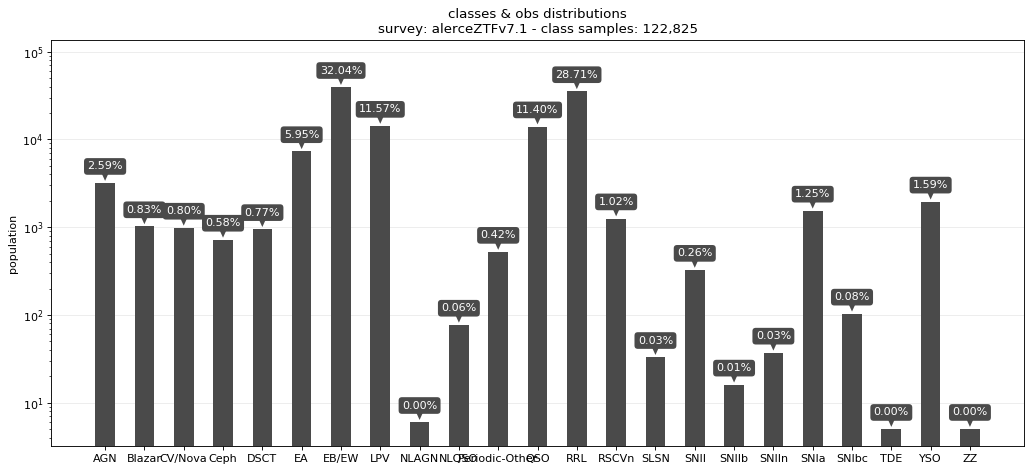

In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from lchandler.survey_export.dictionary_creator import LightCurveDictionaryCreator

band_dictionary = {
    'g':1,
    'r':2,
}
args = [survey_name, detections_df, labels_df, band_dictionary, df_index_names]
kwargs = {
    'obs_is_flux':False,
    'remove_negative_fluxes':True,
    'zero_point':48.6,
    #'maximum_samples_per_class':5000,
}
lcDictionaryCreator = LightCurveDictionaryCreator(*args, **kwargs)
lcDictionaryCreator.plot_class_distribution(figsize=(13,6), uses_log_scale=True)

to_merge_classes_key: merSNII
labels_df:
             classALeRCE          ra        dec period source   id_source  \
oid                                                                         
ZTF18acqyvag        SLSN  143.373154   0.052342    NaN    TNS  SN 2018lfe   
ZTF19aarphwc        SLSN  270.124756  50.295361    NaN    TNS  SN 2019eot   
ZTF18acenqto        SLSN   69.737289 -20.662231    NaN    TNS  SN 2018ibb   
ZTF18acxgqxq        SLSN  348.747162  48.757690    NaN    TNS  SN 2018lfd   
ZTF18abshezu        SLSN  359.324768 -15.631473    NaN    TNS  SN 2018gft   
ZTF19aanesgt        SLSN  124.474709  65.479599    NaN    TNS  SN 2019cdt   
ZTF18acyxnyw        SLSN  186.984299  56.393211    NaN    TNS  SN 2018kyt   
ZTF19aalbrph        SLSN  256.995178  58.701080    NaN    TNS  SN 2019kwq   
ZTF19aaruixj        SLSN  209.415741  64.355186    NaN    TNS  SN 2019kwu   
ZTF19aamhhiz        SLSN  213.768600  50.651886    NaN    TNS  SN 2019kws   
ZTF19abaeyqw        SLSN  212.08242

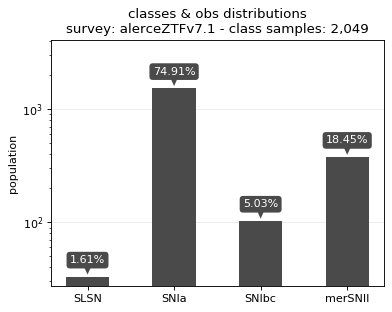

In [16]:
DF_INVALID_CLASSES = []
DF_SN_LIST = ['SLSN' ,'SNII', 'SNIIb', 'SNIIn', 'SNIa', 'SNIbc']

#mode = 'raw'
#mode = 'simple'
#mode = 'transients'
#mode = 'RRCeph'
mode = 'onlySNe'
#mode = 'onlySNIa'

if mode=='simple':
    invalid_classes = DF_INVALID_CLASSES
    query_classes = []
    to_merge_classes_dic = {'SN':DF_SN_LIST,}
    
elif mode=='onlySNe':
    invalid_classes = DF_INVALID_CLASSES
    query_classes = DF_SN_LIST
    to_merge_classes_dic = {'merSNII':['SNII', 'SNIIb', 'SNIIn'],}
    
elif mode=='onlySNIa':
    invalid_classes = DF_INVALID_CLASSES
    query_classes = DF_SN_LIST
    to_merge_classes_dic = {'nonSNIa':['SLSN' ,'SNII', 'SNIIb', 'SNIIn', 'SNIbc'],}

elif mode=='RRCeph':
    invalid_classes = DF_INVALID_CLASSES
    query_classes = ['RRL','Ceph']
    to_merge_classes_dic = {}

lcDictionaryCreator.update_labels_df(invalid_classes, query_classes, to_merge_classes_dic)
lcDictionaryCreator.plot_class_distribution(figsize=(5,4), uses_log_scale=True)

In [17]:
%load_ext autoreload
%autoreload 2

description = 'ZTF Alerce'
save_folder = f'/home/opimentel/tesis/astro-lightcurves-handler/save/{survey_name}'
filename_extra_parameters = {
    'mode':mode,
}
kwargs = {
    'to_export_bands':list(band_dictionary.keys()),
    #'to_export_bands':['g','r'],
    #'SCPD_probs':C_.DEFAULT_SCPD_PS,
    'filename_extra_parameters':filename_extra_parameters,
    'saves_every':1e5,
}
raw_lcdataset = lcDictionaryCreator.export_dictionary(description, save_folder, **kwargs)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
lcobj_names examples: ['ZTF17aadlxmv', 'ZTF18aaaqexr', 'ZTF18aacdbzx', 'ZTF18aadmssd', 'ZTF18aadzfso', 'ZTF18aaermez', 'ZTF18aahatvc', 'ZTF18aahvndq', 'ZTF18aaiiigm', 'ZTF18aailmnv']
to_export_bands: ['g', 'r']
cleaning the DataFrame... - original samples: 12,615,483
remove_invalid_bands - samples: 12,614,223
remove_invalid_classes - samples: 125,663
drop_nans - samples: 125,663
remove_negative_fluxes - samples: 125,663
creating dask DataFrame - npartitions: 4 ...
filedir: /home/opimentel/tesis/astro-lightcurves-handler/save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe.rawlcd
easy_label_dict: {'SLSN': 0, 'SNIa': 1, 'SNIbc': 2, 'merSNII': 3}
100%|██████████| 2049/2049 [172.17it/s, obj: ZTF20abhvnzc - y: 1 - lengths_bdict: {'g': 18, 'r': 20} - pass_cond: True - correct_samples: 2,048]  
last dictionary save! filedir: /home/opimentel/tesis/astro-lightcurves-handler/save/alerceZTFv7.1/survey

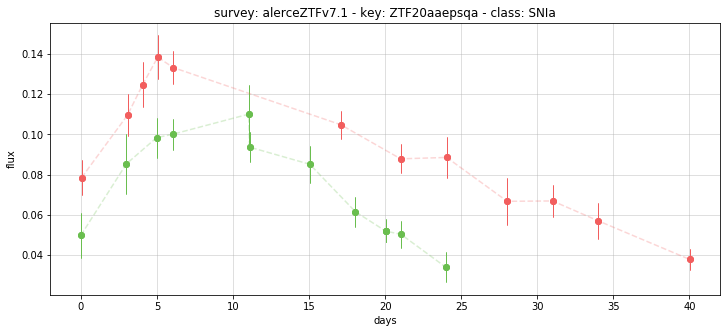

In [23]:
import flamingchoripan.lists as lists
import matplotlib.pyplot as plt
from lchandler.plots.lc import plot_lightcurve

lcset = raw_lcdataset['raw']
lcobj, key = lcset.get_random_lcobj()
fig, ax = plt.subplots(1,1, figsize=(12,5))
for kb,b in enumerate(lcset.band_names):
    plot_lightcurve(ax, lcobj, b)
ax.set_title(f'survey: {lcset.survey} - key: {key} - class: {lcset.class_names[lcobj.y]}')
ax.set_xlabel('days')
ax.set_ylabel('flux')
ax.grid(alpha=0.5)